In [1]:
#!pip install tensorflow

In [2]:
#!pip install opencv-python

In [3]:
#!conda install -y matplotlib

In [4]:
#!conda install -y pandas

# <span style="color:#2ecc71">True</span> vs <span style="color:#e74c3c">Fake</span>

## Face recognition

# We need to import all the differents libraries

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from keras.datasets import fashion_mnist
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
from keras.utils import to_categorical
import os
import matplotlib.pyplot as plt
import numpy as np
#import cv2 as cv
import tensorflow as tf
from concurrent.futures import ThreadPoolExecutor

2024-05-08 21:34:27.806672: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-08 21:34:27.846811: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-08 21:34:27.846835: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-08 21:34:27.847905: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-08 21:34:27.854308: I tensorflow/core/platform/cpu_feature_guar

## We define the path of the Dataset with
- Train
- Test
- Validation

In [6]:
import pathlib

#path=str(pathlib.Path().resolve())+"\\Faces"
path = "/mnt/netapp2/Store_uni/home/xunta/wir/a05/Dataset"

In [7]:
tf.test.is_gpu_available()


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


2024-05-08 21:34:30.728035: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /device:GPU:0 with 13775 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:98:00.0, compute capability: 7.5


True

In [8]:
def get_from_dir(dir):
    global path
    dir = os.path.join(path,dir)
    return tf.keras.utils.image_dataset_from_directory(
           dir,
           labels='inferred',
           color_mode="rgb",
           seed=42,
           batch_size=32,
           image_size=(128, 128))

train = get_from_dir("Train")
test = get_from_dir("Test")
val = get_from_dir("Validation")

Found 140002 files belonging to 2 classes.


2024-05-08 21:34:45.322312: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13775 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:98:00.0, compute capability: 7.5


Found 10905 files belonging to 2 classes.
Found 39428 files belonging to 2 classes.


In [9]:
for images, labels in train.take(1):
    print("Etiqueta de la primera imagen:", labels[0].numpy())

Etiqueta de la primera imagen: 1


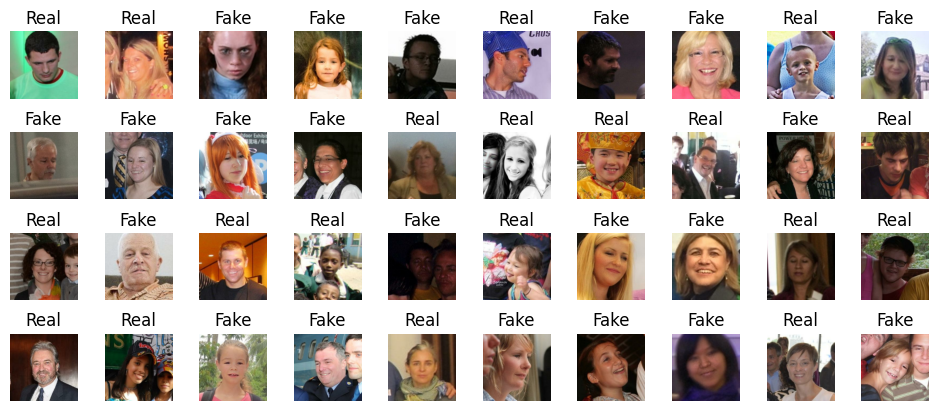

In [10]:
from matplotlib import pyplot as plt

class_names = np.unique(train.class_names)

n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
data = list(train.take(n_rows*n_cols))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        # Obtener solo la primera imagen del lote
        single_image = data[index][0][0]  # Tomar la primera imagen del primer lote
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(single_image.numpy().astype("uint8"),cmap="gray")  # Convertir a tipo uint8 para imshow
        plt.axis('off')
        # Convertir a un solo valor antes de usarlo para indexar class_names
        label_index = data[index][1][0]
        plt.title(class_names[label_index], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()


# Model Processing

In [11]:
model = models.Sequential()

# Va hacer 32 Kernels que serán 3X3 es decir
# Recogera de cada 3 pixeles el central para la nueva imagen 
# Podríamos indicar los Strides (1,1) que son las casillas que avanza
# Le decimos que sea 28 x 28 y que tenga un canal
model.add(layers.Conv2D(32,(3,3),activation="relu", padding='same',input_shape=(128,128,3)))
model.add(layers.Conv2D(32,(3,3),activation="relu", padding='same'))

# Se va reduciendo la imagen por lo que podemos aumentar el número de filtros, donde la imagen se nos va a la mitad
model.add(layers.MaxPooling2D((2,2), strides=(2, 2)))

# Lo normal es aumentar el número de filtros en la imagen
model.add(layers.Conv2D(64,(3,3),activation="relu", padding='same'))
model.add(layers.Conv2D(64,(3,3),activation="relu", padding='same'))
model.add(layers.MaxPooling2D((2,2), strides=(2, 2)))


#model.add(layers.Conv2D(128,(3,3),activation="relu", padding='same'))
#model.add(layers.Conv2D(128,(3,3),activation="relu", padding='same'))
#model.add(layers.MaxPooling2D((2,2), strides=(2, 2)))

# Aplana la capa actual
#model.add(layers.Conv2D(128,(3,3),activation="relu"))
#model.add(layers.Conv2D(128,(3,3),activation="relu"))
model.add(layers.Flatten())

model.add(layers.Dropout(0.5))

model.add(layers.Dense(64,activation="relu"))
model.add(layers.Dense(32,activation="relu"))
model.add(layers.Dense(1,activation="sigmoid"))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 32)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 32, 32, 64)        0         
 g2D)                                                   

In [12]:
model.compile('adam',loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [13]:
keras.utils.plot_model(model, "prediction.png", show_shapes=True,show_dtype=True,show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [14]:

#gpus = tf.config.experimental.list_physical_devices('GPU')
#print(gpus)
#tf.config.set_visible_devices([], 'CPU') # hide the CPU
#tf.config.set_visible_devices(gpus[0], 'GPU') # unhide potentially hidden GPU
#tf.config.get_visible_devices()


#cpus = tf.config.experimental.list_physical_devices('CPU')
#print(cpus)
#tf.config.set_visible_devices([], 'GPU')  # hide the GPU
#tf.config.set_visible_devices(cpus[0], 'CPU') # unhide potentially hidden CPU
#tf.config.get_visible_devices()

early_stopping_cb = keras.callbacks.EarlyStopping(patience=5,restore_best_weights=True)


history = model.fit(train,epochs=20,batch_size=32,validation_data=val,callbacks=[early_stopping_cb])

Epoch 1/20


2024-05-08 21:34:56.641442: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
2024-05-08 21:34:59.545863: I external/local_xla/xla/service/service.cc:168] XLA service 0x1546ea3248c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-08 21:34:59.545885: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2024-05-08 21:34:59.551459: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1715196899.667246 4126828 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


4376/4376 [==============================] - 198s 44ms/step - loss: 0.3596 - accuracy: 0.8483 - val_loss: 0.3230 - val_accuracy: 0.8611
Epoch 2/20
4376/4376 [==============================] - 190s 43ms/step - loss: 0.2075 - accuracy: 0.9145 - val_loss: 0.2424 - val_accuracy: 0.8963
Epoch 3/20
4376/4376 [==============================] - 193s 44ms/step - loss: 0.1706 - accuracy: 0.9293 - val_loss: 0.2346 - val_accuracy: 0.9017
Epoch 4/20
4376/4376 [==============================] - 182s 42ms/step - loss: 0.1445 - accuracy: 0.9417 - val_loss: 0.2942 - val_accuracy: 0.8894
Epoch 5/20
4376/4376 [==============================] - 189s 43ms/step - loss: 0.1263 - accuracy: 0.9492 - val_loss: 0.2017 - val_accuracy: 0.9230
Epoch 6/20
4376/4376 [==============================] - 190s 43ms/step - loss: 0.1111 - accuracy: 0.9562 - val_loss: 0.2079 - val_accuracy: 0.9213
Epoch 7/20
4376/4376 [==============================] - 182s 42ms/step - loss: 0.0969 - accuracy: 0.9628 - val_loss: 0.1819 - val

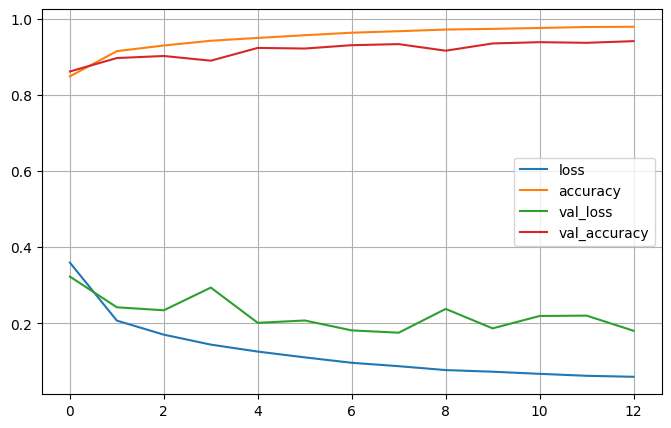

In [15]:
import matplotlib.pyplot as plt

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.show()

In [16]:
model.evaluate(test)

341/341 [==============================] - 33s 88ms/step - loss: 0.2546 - accuracy: 0.8948


[0.2546384334564209, 0.894818902015686]

In [17]:
model.save("modelo_detector_caras.keras")

In [18]:
test.shuffle = False

In [19]:
predicciones = model.predict(test)
predicciones = (predicciones >= 0.5).astype(int)

341/341 [==============================] - 10s 28ms/step


1/1 [==============================] - 0s 80ms/step


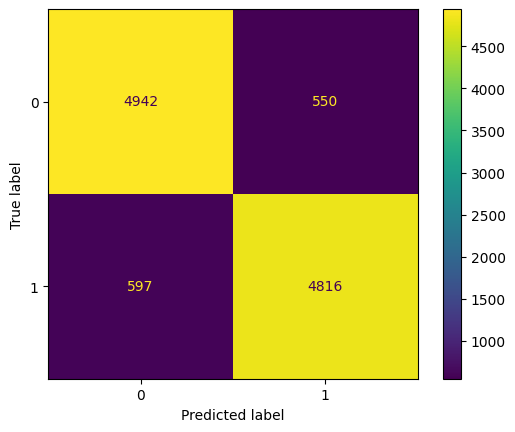

In [20]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Obtener las etiquetas verdaderas y las predicciones
true_labels = []
predictions = []

for images, labels in test:
    true_labels.extend(labels.numpy())
    batch_predictions = model.predict(images) >= 0.5
    predictions.extend(batch_predictions.astype(int).flatten())

true_labels = np.array(true_labels)
predictions = np.array(predictions)

cm = confusion_matrix(true_labels, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

